<a href="https://colab.research.google.com/github/rhqtmfajfl/python-study/blob/master/RNN/05_Seq2Seq_%EA%B8%B0%EB%B3%B8%EA%B5%AC%ED%98%84_0723.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM의 `return_sequences`, `return_state` 이해하기
* `return_sequences` : 매 타임 스텝의 출력 여부 결정 결정
* `return_state` : 제일 마지막 스테이트 출력 여부 결정

LSTM() 사용시 return_sequences 가 False라면 첫번째 결과는 마지막 시점의 은닉 상태이다.

 LSTM이 SIMPLERNN과 다른 점은 return_state를 True로 둔 경우에는 마지막 시점의 은닉 상태뿐아니라 셀 상태까지 반환한다는 점이다. 이번에는 return_sequences를 True로 바꿔본다면

In [2]:
import numpy as np
from tensorflow.keras.layers import LSTM

In [3]:
test= np.random.randn(1,1, 4, 5) # 4차식이 만들어 진다.

In [4]:
sample_train = np.random.randn(1, 4, 5) # N L I N 입력차원의 개 : (데이터 개수, 최대타임스탭, 임베딩차원)

In [5]:
sample_train# 가우시안 표준 정규 분포에서 난수 생성 1, 4, 5 3차식 4행 5열이 만들어 진다. 

array([[[ 0.53885283,  1.29441981, -0.2114026 ,  0.63150479,
          1.10182994],
        [ 0.75362125,  1.02647357, -1.86865963, -0.34206019,
         -0.90312052],
        [ 1.04857704,  1.34359074,  0.24265928, -0.41792502,
         -0.46650484],
        [-0.79287956, -2.79584681,  0.32751437,  1.24284149,
          0.8475105 ]]])

`return_sequences=False`, `return_state=False`


In [6]:
# 제일 마지막 HIDDEN STATE 만 반환 된다.

last_hidden_state = LSTM(3, return_sequences=False, return_state=False)(sample_train)
print(last_hidden_state) # 마지막 히든 스테이트만 나오게 된다.
# 1행 3열의 형태로 나온다.

tf.Tensor([[ 0.04990231  0.02883668 -0.10879944]], shape=(1, 3), dtype=float32)


`return_sequences=False`, `return_state=True`

* `hidden_states` = `last_hidden_state`
* `last_cell_state`

In [7]:
hidden_states, last_hidden_state, last_cell_state = LSTM(3, return_sequences=False, return_state=True)(sample_train)
print("hidden_states : {}".format(hidden_states)) # 맨 앞은 안쓴다. 인코더에서
print("last_hidden_state : {}".format(last_hidden_state))
print("last_cell_state : {}".format(last_cell_state))

hidden_states : [[-0.33115745  0.21380037 -0.04245656]]
last_hidden_state : [[-0.33115745  0.21380037 -0.04245656]]
last_cell_state : [[-0.4300225   0.35645208 -0.27805108]]


`return_sequences=True`, `return_state=False`


In [8]:
hidden_states = LSTM(3, return_sequences=True, return_state=False)(sample_train)
print("hidden_states : {} / shape : {}".format(hidden_states, hidden_states.shape))


hidden_states : [[[ 0.15874124 -0.00894629 -0.14829081]
  [ 0.10093828 -0.28140265 -0.08538203]
  [ 0.04589    -0.41690886 -0.04804548]
  [ 0.33217064 -0.10021503 -0.12777239]]] / shape : (1, 4, 3)


`return_sequences=True`,`return_state=True`

In [9]:
hidden_states, last_hidden_state, last_cell_state = LSTM(3, return_sequences=True, return_state=True)(sample_train)
print("hidden_states : {}".format(hidden_states))
print("last_hidden_state : {}".format(last_hidden_state))
print("last_cell_state : {}".format(last_cell_state))

hidden_states : [[[ 0.04541929 -0.07401614 -0.1427773 ]
  [ 0.21732126 -0.08576818 -0.17878628]
  [ 0.23667152 -0.20406769 -0.09278145]
  [-0.12823175 -0.03186169 -0.3409482 ]]]
last_hidden_state : [[-0.12823175 -0.03186169 -0.3409482 ]]
last_cell_state : [[-0.27751046 -0.0456894  -0.4190282 ]]


## Seq2Seq 챗봇 만들기


In [10]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 448 kB 57.5 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [11]:
import random # 나중에 데이터 셔플링 할 예정
import tensorflow as tf
from konlpy.tag import Okt

# 하이퍼 파라미터

In [12]:
num_epochs = 200
vocab_size = 2000

# Encoder

In [125]:
# class Encoder(tf.keras.Model):
#   def __init__(self):
#     super(Encoder, self).__init__()
#     # 정수인코딩하고 -> 임베딩 레이어에 넣는다.
#     self.emb = tf.keras.layers.Embedding(vocab_size, 64) # 임베딩차원도 64개 , 임베딩 레이어 지정
    
#     # 제일 마지막 state를 리턴해야 context vector가 나옴!
#     self.lstm = tf.keras.layers.LSTM(512, return_sequences=False, return_state=True) # lsmt 레이어 마듬

#     # return_seq false 는 위쪽에 있는 내용을 볼 필욕 없기 때문에 false이다.
#     # 셀과 히든을 디코더로 넘겨야 하기 때문에 retrun s_state true로 함
#   def call(self, training=False):
#     # 데이터가 들어온다 
#     # 임베딩 레이어
#     x = self.emb(x)

#     # Encoder에서는 context vector 만 얻어내면 되기 때문에 각 time 별 state는필요가 없다.
#     _, h, c = self.lstm(x)
#     # _ 제일 앞에 time별 state는 필요가 없다.
#     #context vector return
#     # 컨텍스트 리턴 
#     return h, c
class Encoder(tf.keras.Model):
  def __init__(self):
    super(Encoder, self).__init__()
    self.emb  = tf.keras.layers.Embedding(vocab_size, 64)

    # 제일 마지막 state를 리턴해야 context vector가 나옴!
    self.lstm = tf.keras.layers.LSTM(512, return_sequences=False, return_state=True)

  def call(self, x, training=False):
    # 임베딩
    x = self.emb(x)

    # Encoder에서는 context vector만 얻어내면 되기 때문에 각 time 별 state는 필요가 없다.
    _, h, c = self.lstm(x)

    # context vector return
    return h, c

# Decoder

In [124]:
# class Decoder(tf.keras.Model):
#   def __init__(self):
#     super(Decoder, self).__init__()
#     # 여기도 임베딩이 있어야 하낟.
#     self.emb= tf.keras.layers.Embedding(vocab_size, 64) # 언어 인코딩 만들려면 각 언어들마다의 임베딩 벡터를 만들어야 한다.
#     self.lstm = tf.keras.layers.LSTM(512, return_sequences = True, return_state=True ) # 512로 한 이유 논문에서 구현된내용이다.
#     # 인코더와 다른 이유 리턴 시퀀스와 리턴 스테이트가 True다. 
#     # 시퀀스가 트루여야 다음 단어가 어떤 걸지 예측이 가능하다.
#     # 리턴 스테이트 트루이면 테스트를 할 때 이오에스가 생기면 끝나므로 리턴스테이트를 트루로 해줘야 셀과 히든이 생긴다.
#     # 계층이 64번 돌아간다.
#     # lstm 이 필요

#     #각 셀마다 2000개의 output을내고, 어떤 단어가추정 되었을 지를 계산 Dense 레이어 필요 vocabsize 만큼의 층이 덴스가 있어야 예측이 가능
#     self.dense = tf.keras.layers.Dense(vocab_size, activation='softmax') # 단어 2000개의 데이터에서 softmax의 결과를 낸다.

#   def call(self, inputs, training=False):
#     #입력된  데이터들
#     x, h, c = inputs # shifted, (hidden_state, cell_state) #한칸 밀린데이터가 들어온다.
#     # 히든 스테이트고 셀스테이트기도 하지만 그냥 값이다.
#     x = self.emb(x) # 입력한 단어에 대한 임베딩벡터
#      # wx+b에 대한 값만 기억하고 있기

#       # x에서 단어한개가 들어오고 
#       # emb에서 임베딩 레이어 거친다.

#     #y_ : 해당 시퀀스의 hidden_state
#     y_, h, c = self.lstm(x, initial_state=[h,c]) # initial_state : 초기화할 hidden_state, cell_state를 지정
#     #  y_ 결과물
#     # y 값이랑 h, c 가 다음 단계로 넘어갈 값이 된다.

#     y = self.dense(y_) # 결과물을 dense레이어에 집어 넣는다.
#     #그리고 다음 단계로 넘어갈때 y와 h,c 도 같이 넘겨준다.

#     return y, h, c
class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder, self).__init__()
    self.emb = tf.keras.layers.Embedding(vocab_size, 64)
    self.lstm = tf.keras.layers.LSTM(512, return_sequences=True, return_state=True)

    # 각 셀마다 2000개의 output을 내고, 어떤 단어가 추정 되었 을지를 계산
    self.dense = tf.keras.layers.Dense(vocab_size, activation='softmax')

  def call(self, inputs, training=False):
    x, h, c = inputs # shifted, hidden_state, cell_state
    x = self.emb(x) # 입력한 단어에 대한 임베딩 벡터

    # y_ : 해당 시퀀스의 hidden_state
    y_, h, c = self.lstm(x, initial_state=[h, c]) # initial_state : 초기화 할 hidden_state, cell_state를 지정

    y = self.dense(y_)

    return y, h, c

# Seq2Seq

In [123]:
# class Seq2seq(tf.keras.Model):
#   #sos최초값을 넣느다.eos도 넣는다.
#   def __init__(self, sos, eos):
#     super(Seq2seq, self).__init__()
#     self.sos = sos # decoder에서 사용되어질 sos
#     self.eos = eos # encoder에서 사용되어질 eos
    
#     self.enc = Encoder()
#     self.dec = Decoder() # enc와 dec를 엮어 줄 것이다.

#   def call(self, inputs, training=False):
#     if training: # 훈련시에서는 Teacher Forcing 때문에 정답이 들어옴
#       x, y  = inputs # 정답이 그대로들어감 기본 입력데이터(output_labels, shifted labels)

#       h, c = self.enc(x) # context vector가 등장 (들어감) 인코더에 대한 컨텍스트 벡터를 받아옴 # 여기서 x는 시퀀스에 들어갈 x 이다.

#       # y의 shape은 전체 데이터를 모두 가지고 있는 상태가 된다.
#       # y.shape :(N, 65, 64) # 최대 단어수 64개가 64개씩 들어간다.
#       y, _, ___ = self.dec((y,h, c))#teacher forcing Decoder의 입력으로 Shifted Output을 넣어줌
#       # y정답과 레이블을묶은 레이어가 들어오고 h,c는 컨텍스트 벡터에서의 값이 된다.


#       #길이가 정해진 값들이 들어오게 됨
      

#       return y # 훈련된 결과가 나옴
#     else: # 테스트 할 때는 x 만 들어온다.
#       x = inputs
#       # x엗 해나 히든과 셀스테이트
#       h, c = self.enc(x) # last_cell_state, last_hidden_state

#       # 시퀀셜 스테이트는없다.

#       #<sos> 입력
#       #1. <sos> 토큰을 tensor 배열화 시켜야함
#       y = tf.convert_to_tensor(self.sos) # 0 rank tensor로 변환
#       y = tf.reshape(y, (1,1)) # <sos> 가 (1,1) 형식으로 변환 (1배치, 1타임 스텝)을 의미, embedding 레이어에 넣을 예정
#       #(1,1) 단어하나 LENGTH 하나 

#       # 최대 입력 길이 만큼의 공간을미리 만들어 놓자
#       seq = tf.TensorArray(tf.int32, 64) # 64개의 텐서 배열 만들어 놓기 # SEQ 는 배열을 쌓아놓는것 32개씩 64개를 가질수 있도록
    
#       # tensorflow의 session 환경에서 for 무을 조금더 빠르게 돌릴 수 있따.
#       for idx in tf.range(64):
#         # 제일 첨음엔 <sos>, 인코더의 h, c (context vector)가 들어간다.

#         ###########################################################################################################여기가 핵심
#         y, h, c = self.dec([y,h,c]) # 여기서 리턴 받는 y는 softmax의 결과 다음 시퀀스에 대한 소프트맥스 결과  
#         #######################################################################################################
#         #
        
#         y = tf.cas(tf.argmax(y, axis= -1), dtype=tf.int32) #-1은 y는 0부터 1999중에 가장 큰것이 등장

#         # 한문장 들어가서 하나의 결과, 1배치 들어가니까 나오는 것도 1개
#         y = tf.reshape(y, (1,1)) # (1 배치, 1단어를 의미하기 위해 reshape - 테스트 할 때는 배치를 1로 설정할 예정) # 한문장

#         seq = seq.write(idx, y) # 순서대로 write

#         if y == self.eos:
#           break

#       return tf.reshape(seq.stack(), (1,64)) # 1의 64 형태로 리세이프 쌓아간다.
class Seq2seq(tf.keras.Model):
  
  def __init__(self, sos, eos):
    super(Seq2seq, self).__init__()
    self.sos = sos # decoder에서 사용되어질 sos
    self.eos = eos # encoder에서 사용되어질 eos

    self.enc = Encoder()
    self.dec = Decoder()

  def call(self, inputs, training=False):
    
    if training: # 훈련에서는 Teacher Forcing 때문에 정답이 들어옴

      x, y = inputs # (output_labels, shifted labels)
      h, c = self.enc(x) # context vector가 등장
      
      y, _, __ = self.dec((y, h, c)) # teacher forcing. Decoder의 입력으로 Shifted Output을 넣어줌
      
      return y
    else: # 테스트 할 때는 x만 들어 온다..
      x = inputs
      h, c = self.enc(x) # last_cell_state, last_hidden_state
      
      # <sos> 입력
      # <sos> 토큰을 tensor 배열화 시켜야 함
      y = tf.convert_to_tensor(self.sos) # 0 rank tensor로 변환
      y = tf.reshape(y, (1, 1)) # <sos>가 (1, 1)형식으로 변환. ( 1배치, 1타임 스텝)을 의미. embedding 레이어에 넣을 예정

      # 최대 입력 길이 만큼의 공간을 미리 만들어 놓자
      seq = tf.TensorArray(tf.int32, 64) # 64개의 텐서 배열 만들어 놓기

      # tensorflow의 session 환경에서 for문을 조금 더 빠르게 돌릴 수 있다!
      for idx in tf.range(64):
        # 제일 처음엔 <sos>, 인코더의 h, c (context vector)가 들어간다.
        ############################################################
        y, h, c = self.dec([y, h, c]) # 리턴 받는 y는 softmax의 결과
        ############################################################
        y = tf.cast(tf.argmax(y, axis=-1), dtype=tf.int32)

                                  # 한 문장 들어 가서 하나의 결과. 1배치가 들어가니까 나오는 것도 1개
        y = tf.reshape(y, (1, 1)) # (1 배치, 1단어를 의미하기 위해 reshape - 테스트 할 때는 배치를 1로 설정할 예정..)

        seq = seq.write(idx, y) # 순서대로 write

        if y == self.eos:
          break
      
      return tf.reshape(seq.stack(), (1, 64))

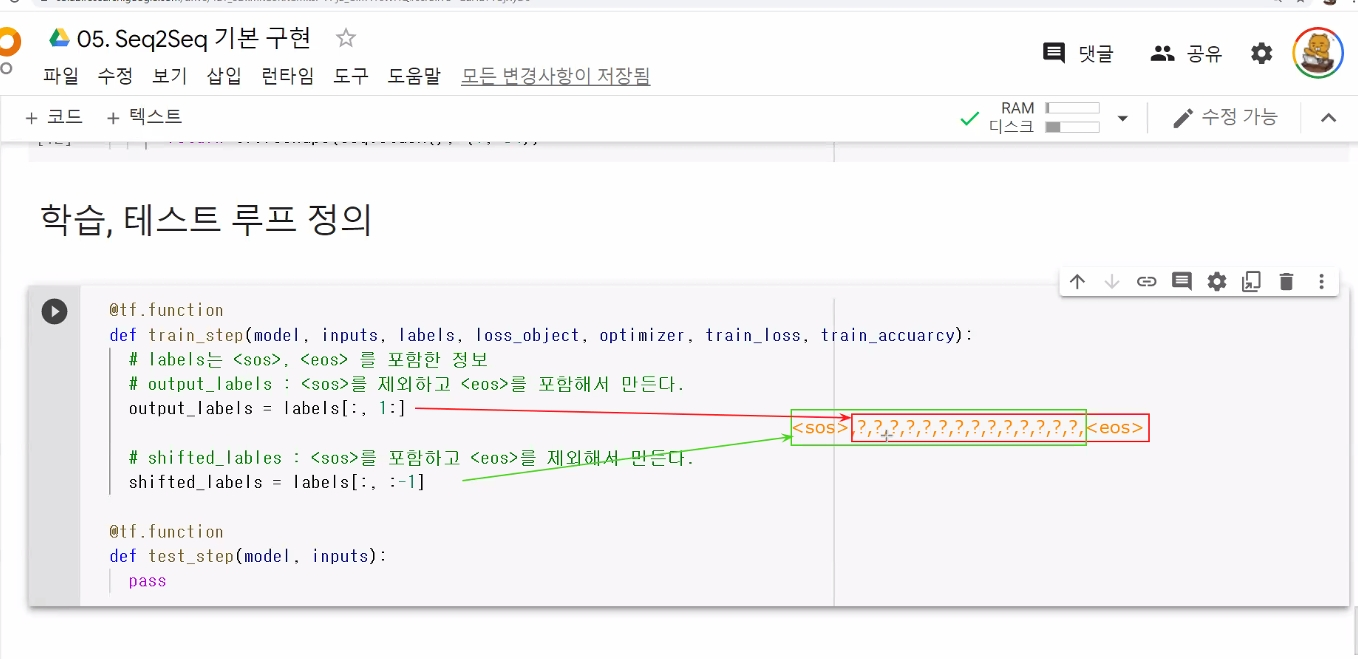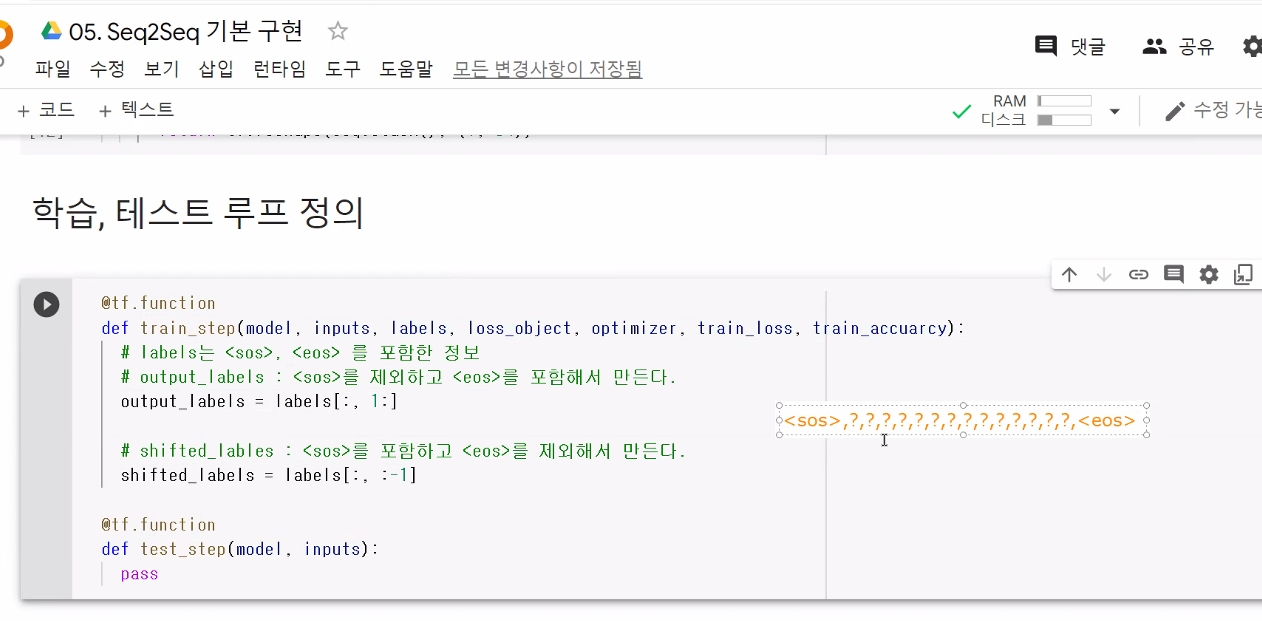

# 학습, 테스트 루프 정의

In [144]:
# @tf.function
# def train_step(model, inputs, labels, loss_object, optimizer, train_loss, train_accuarcy):
#  # 필요한게 모델 , 입력값 레벨, 로스 오브젝트, 옵티마이저 , 트레인 로스 , 트레인 머큐러시
#   #labels는 <sos>, <eos>를 포함한 정보이다.
#   # output_labels : <sos>를 제외하고 <eos>를 포함해서 만든다.
#   output_labels = labels[:, 1:]

#   #shifted_labels : <sos>를 포함하고, <eos>를 제외해서 만든다.
#   shifted_labels = labels[:, :-1] # sos를 포함하면서 eos를 제외한다.실제 사용할 수 있는 것은 63개 밖에 안된다.

#   with tf.GradientTape() as tape: # tf.GradientTape 에서 tape 자동 미분 해준다
#     #inputs : x의 역할, Encoder에 들어감
#     # shifted_labels : 디코더가 예측하고 ,예측해야할 데이터
#     predictions = model([inputs, shifted_labels], training=True) # 이 모델이 트레이닝 모드로 예측 # 여기서 예측을 하고,
#     loss = loss_object(output_labels, predictions) # 정답이 이거였어~ 라고 이야기 하는 것
  
#   gradients = tape.gradient(loss, model.trainable_variables)
#   optimizer.apply_gradients(zip(gradients,model.trainable_variables))
  
#   train_loss(loss)
#   train_accuracy(output_labels, predictions) # 여기까지로 훈련을 마침

# @tf.function
# def test_step(model, inputs): # 모델과 인풋 필요
#   # 입력 데이터만 주고 추론은 모델이 알아서 할 수 있도록...
#   return model(inputs, training=False)
@tf.function
def train_step(model, inputs, labels, loss_object, optimizer, train_loss, train_accuarcy):
  # labels는 <sos>, <eos> 를 포함한 정보
  # output_labels : <sos>를 제외하고 <eos>를 포함해서 만든다.
  output_labels = labels[:, 1:]
  # shifted_lables : <sos>를 포함하고 <eos>를 제외해서 만든다.
  shifted_labels = labels[:, :-1]

  with tf.GradientTape() as tape:
    # inputs : x의 역할. Encoder에 들어감
    # shifted_labels : Encoder가 예측하고, 예측해야 할 데이터
    predictions = model([inputs, shifted_labels], training=True) # 예측을 하고
    loss = loss_object(output_labels, predictions) # 정답이 이거였어~ 라고 이야기 하는 것
  
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients,model.trainable_variables))
  
  train_loss(loss)
  train_accuracy(output_labels, predictions)

@tf.function
def test_step(model, inputs):
  # 입력 데이터만 주고 추론은 모델이 알아서 할 수 있도록...
  return model(inputs, training=False)

In [92]:
 # chatbot_data를 불러온다.

# 데이터셋 준비
* http://www.aihub.or.kr

In [127]:
# from konlpy.tag import Okt

# dataset_file = 'chatbot_data.csv'
# okt = Okt()
from konlpy.tag import Okt

dataset_file = "chatbot_data.csv"
okt = Okt()

In [128]:
# with open(dataset_file, 'r') as file:
#   lines = file.readlines()
#   seq = [' '.join(okt.morphs(line)) for line in lines]
with open(dataset_file, 'r') as file:
  lines = file.readlines()
  seq = [" ".join(okt.morphs(line)) for line in lines]

In [129]:
seq[:6]

['아이스 아메리카노 하나요 \n',
 '테이크아웃 하실 건가 요 ? \n',
 '저 카푸치노 로 주문 할게요 \n',
 '시럽 은 얼마나 뿌려 드릴 까요 ? \n',
 '저 도장 다 모았는데 나중 에 써도 되나요 ? \n',
 '네 다음 에 써도 됩니다 \n']

In [130]:
# # 백슬러시 태그를 기준으로 응답이 된다. # 앞에 백슬러시 태그가 붙으면 대답이 된다.
# #
# questions = seq[::2]
# answers = ["\t " + lines for lines in seq[1::2]] # \t : <sos> # 여기서 "\t " 한칸 띄워줘야하낟.

# print(questions[:3])
# print(answers[:3])
questions = seq[::2]
answers = ["\t " + lines for lines in seq[1::2]] # \t : <sos>

print(questions[:3])
print(answers[:3])

['아이스 아메리카노 하나요 \n', '저 카푸치노 로 주문 할게요 \n', '저 도장 다 모았는데 나중 에 써도 되나요 ? \n']
['\t 테이크아웃 하실 건가 요 ? \n', '\t 시럽 은 얼마나 뿌려 드릴 까요 ? \n', '\t 네 다음 에 써도 됩니다 \n']


# 데이터 잘라내기

In [131]:
# num_samples = len(questions) #질문의 개수
# print(num_samples)
num_samples = len(questions)
print(num_samples)

500


In [132]:
# import random 

# term = list(range(num_samples))#term을 리스트로 만듬
# print('섞이기 전 : {}'.format(term))
# #랜덤 시드 고정
# random.seed(0)
# random.shuffle(term)

# print('섞인 후 : {}'.format(term[:10]))
term = list(range(num_samples))
print("섞이기 전 : {}".format(term[:10]))
# 랜덤 시드 고정
random.seed(0)
random.shuffle(term)

print("섞인 후 : {}".format(term[:10]))

섞이기 전 : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
섞인 후 : [419, 459, 130, 431, 370, 26, 201, 56, 366, 108]


* questions : 입력데이터(inputs)
* answers : 예측 레이블(outputs)

In [133]:
# train_q = [] # x_train
# train_a = [] # y_train

# test_q = [] # x_test
# test_a = [] # y_test
train_q = [] # X_train
train_a = [] # y_train

test_q = [] # X_test
test_a = [] # y_test

In [134]:
# test_ratio = 0.2
# test_cnt = int(len(questions) * test_ratio) # train count가 나온다.


# train_indices = term[test_cnt:]
# test_indices = term[:test_cnt]

# print(len(train_indices), len(test_indices))

# for idx in train_indices:
#   train_q.append(questions[idx])
#   train_a.append(answers[idx])

# for idx in test_indices:
#   test_q.append(questions[idx])
#   test_a.append(answers[idx])
# # for idx, qna in enumerate(zip(questions, answers)):
# #   # print(qna)
# #   q, a = qna # qna 언패킹

#   # if term[idx] > num_samples // 5: # 
test_ratio = 0.2
test_cnt = int(len(questions) * test_ratio)

train_indices = term[test_cnt: ]
test_indices  = term[:test_cnt]

for idx in train_indices:
  train_q.append(questions[idx])
  train_a.append(answers[idx])

for idx in test_indices:
  test_q.append(questions[idx])
  test_a.append(answers[idx])

In [135]:
# test_q[:3], test_a[:3]
test_q[:3], test_a[:3]

(['사이 즈 업 해서 주세요 \n',
  '캐러멜 드리블 이랑 통 잡아 칩이요 \n',
  '시즌 메뉴 와 함께 구성 되어 있는 세트 메뉴 가 있나요 ? \n'],
 ['\t 네 결제 는 어떻게 도 와 드릴 까요 ? \n',
  '\t 6700원 결제 도 와 드리겠습니다 \n',
  '\t 네 치즈 케이크 와 시즌 메뉴 두 잔 으로 구성 된 세트 메뉴 있습니다 \n'])

# 토크나이징

In [136]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenizer = Tokenizer(num_words = vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~') # 챗봇 만들때는 oov 처리를 안함
# # 뒤의 특수문자들을 제거하도록 한다. 
# # 보캡사이즈로 단어를 2000개 까지 사용
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~')

In [137]:
# # 토큰화 시킬때
# tokenizer.fit_on_sequences(train_q + train_a) # 질문과 대답의 모든 내용을 토큰화 시킨다.
# print(tokenizer.word_index)
tokenizer.fit_on_texts(train_q + train_a) # 질문과 대답의 모든 내용을 토큰화
print(tokenizer.word_index)

{'\n': 1, '\t': 2, '네': 3, '주세요': 4, '로': 5, '아메리카노': 6, '는': 7, '에': 8, '아이스': 9, '도': 10, '요': 11, '잔': 12, '이': 13, '한': 14, '드릴': 15, '까요': 16, '은': 17, '입니다': 18, '사이즈': 19, '가': 20, '있나요': 21, '결제': 22, '수': 23, '하나': 24, '있습니다': 25, '와': 26, '드시고': 27, '해주세요': 28, '할게요': 29, '으로': 30, '라테': 31, '추가': 32, '따뜻한': 33, '주문': 34, '사용': 35, '음료': 36, '되나요': 37, '여기': 38, '아니요': 39, '거': 40, '얼마': 41, '개': 42, '그럼': 43, '카드': 44, '랑': 45, '드리겠습니다': 46, '케이크': 47, '어떤': 48, '걸': 49, '포인트': 50, '가시나요': 51, '한잔': 52, '할인': 53, '적립': 54, '다': 55, '커피': 56, '더': 57, '인가요': 58, '쿠폰': 59, '가요': 60, '드릴게요': 61, '티': 62, '건': 63, '가능합니다': 64, '알겠습니다': 65, '에서': 66, '가능한가요': 67, '매장': 68, '를': 69, '진동': 70, '면': 71, '벨': 72, '안': 73, '번호': 74, '만': 75, '에요': 76, '메뉴': 77, '하나요': 78, '디카': 79, '페인': 80, '건가': 81, '샷': 82, '있어요': 83, '됩니다': 84, '테이크아웃': 85, '예요': 86, '스무디': 87, '게': 88, '카페라테': 89, '두': 90, '같이': 91, '자몽': 92, '하고': 93, '치즈케이크': 94, '제일': 95, '뭐': 96, '카페모카': 97, '기프티콘': 98, '세트':

In [104]:
# tokenizer.fit_on_texts(train_q + train_a) # 질문과 대답의 모든 내용을 토큰화
# print(tokenizer.word_index)

{'\n': 1, '\t': 2, '네': 3, '주세요': 4, '로': 5, '아메리카노': 6, '는': 7, '에': 8, '아이스': 9, '도': 10, '요': 11, '잔': 12, '이': 13, '한': 14, '드릴': 15, '까요': 16, '은': 17, '입니다': 18, '사이즈': 19, '가': 20, '있나요': 21, '결제': 22, '수': 23, '하나': 24, '있습니다': 25, '와': 26, '드시고': 27, '해주세요': 28, '할게요': 29, '으로': 30, '라테': 31, '추가': 32, '따뜻한': 33, '주문': 34, '사용': 35, '음료': 36, '되나요': 37, '여기': 38, '아니요': 39, '거': 40, '얼마': 41, '개': 42, '그럼': 43, '카드': 44, '랑': 45, '드리겠습니다': 46, '케이크': 47, '어떤': 48, '걸': 49, '포인트': 50, '가시나요': 51, '한잔': 52, '할인': 53, '적립': 54, '다': 55, '커피': 56, '더': 57, '인가요': 58, '쿠폰': 59, '가요': 60, '드릴게요': 61, '티': 62, '건': 63, '가능합니다': 64, '알겠습니다': 65, '에서': 66, '가능한가요': 67, '매장': 68, '를': 69, '진동': 70, '면': 71, '벨': 72, '안': 73, '번호': 74, '만': 75, '에요': 76, '메뉴': 77, '하나요': 78, '디카': 79, '페인': 80, '건가': 81, '샷': 82, '있어요': 83, '됩니다': 84, '테이크아웃': 85, '예요': 86, '스무디': 87, '게': 88, '카페라테': 89, '두': 90, '같이': 91, '자몽': 92, '하고': 93, '치즈케이크': 94, '제일': 95, '뭐': 96, '카페모카': 97, '기프티콘': 98, '세트':

정수 인코딩


In [138]:
# train_q_seq = tokenizer.texts_to_sequences(train_q)
# train_a_seq = tokenizer.texts_to_sequences(train_a)

# test_q_seq = tokenizer.texts_to_sequences(test_q)
# test_a_seq = tokenizer.texts_to_sequences(test_a)

# train_q_seq[:3], train_a_seq[:3]
train_q_seq = tokenizer.texts_to_sequences(train_q)
train_a_seq = tokenizer.texts_to_sequences(train_a)

test_q_seq  = tokenizer.texts_to_sequences(test_q)
test_a_seq  = tokenizer.texts_to_sequences(test_a)

train_q_seq[:3], train_a_seq[:3]

([[85, 12, 30, 4, 1], [3, 239, 1], [3, 300, 301, 47, 4, 1]],
 [[2, 627, 628, 629, 73, 66, 630, 631, 35, 113, 23, 378, 1],
  [2, 57, 162, 63, 139, 60, 1],
  [2, 36, 7, 227, 5, 15, 16, 1]])

패딩 후 최종 데이터 마련하기

In [139]:
# # eos로 쓸 것이 필요하다 \n

# #문장의 최대길이 64로 설정 했음!
# x_train = pad_sequences(
#     train_q_seq,
#     value=0, # 값을 0으로 채운다.
#     padding='pre',
#     maxlen=64 # x_train과 test는 sos가 필요없이 확실 하기 때문에 64개이다.
# )

# # y_train = pad_sequences(
# #     train_a_seq,
# #     value =0,
# #     padding='post'
# #     maxlen = 65 # 65가 되는 이유 <sos> <eos>도 같이 붙으니까 <sos> .........<eos> 실제 예측이 되는 것은 63개가 한계이다.
# # )

# y_train = pad_sequences(
#     train_a_seq,
#     value=0,
#     padding='post',
#     maxlen=65 # <sos>, <eos>
# )
# x_test = pad_sequences(
#     test_q_seq,
#     value=0,
#     padding='pre',
#     maxlen=64
# )

# y_test = pad_sequences(
#     test_a_seq, 
#     value=0,
#     padding='post',
#     maxlen=65
# )
# 문장의 최대길이 64로 설정 했음!
X_train = pad_sequences(
    train_q_seq,
    value=0,
    padding='pre',
    maxlen=64
)

y_train = pad_sequences(
    train_a_seq,
    value=0,
    padding='post',
    maxlen=65 # <sos>, <eos>
)

X_test = pad_sequences( test_q_seq, value=0, padding='pre', maxlen=64 )
y_test = pad_sequences( test_a_seq, value=0, padding='post', maxlen=65 )

In [140]:
# x_train[0], y_train[0]
X_train[0], y_train[0]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 85, 12, 30,  4,  1], dtype=int32),
 array([  2, 627, 628, 629,  73,  66, 630, 631,  35, 113,  23, 378,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       dtype=int32))

In [141]:
# train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).batch(32).prefetch(1024) # prefetch : 데이터를 미리 저장할 공간을 의미
# test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(1).prefetch(1024)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1024).batch(32).prefetch(1024) # prefetch : 데이터를 미리 저장할 공간을 의미
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1).prefetch(1024)

In [109]:
#prefetch를 쓰면 약간 속도가 빨라지는 효과가 있다.

# 학습 환경 정의
모델 생성, 손실 함수, 최적화 알고리즘, 평가지표 정의

In [110]:
# t와 y^ 의 로스를 구한다. 
# yt가 들어와서 임베딩 된다.

In [142]:
# # 모델 생성
# model = Seq2seq(sos = tokenizer.word_index['\t'],
#                 eos = tokenizer.word_index['\n']
                
#   )

# # Loss 함수 선정 정수 인코딩된 결과를 t로 사용, softmax 및 argmax를 이용한 점수값을 예측으로 쓰니까 sparse_cartegorical_crossentropy
# loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
# optimizer = tf.keras.optimizers.Adam()

# #모델 평가 방식
# train_loss = tf.keras.metrics.Mean(name = 'train_loss')
# train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
# 모델 생성
model = Seq2seq(
    sos=tokenizer.word_index["\t"],
    eos=tokenizer.word_index["\n"]
)

# Loss 선정. 정수 인코딩된 결과를 t로 사용, softmax 및 argmax를 이용한 정수값을 예측으로 쓰니까 sparse_categorical_crossentropy
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# 모델 평가 방식
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# 학습 루프 동작

In [145]:
# EPOCHS = 200
# for epoch in range(EPOCHS):
#   for seqs, labels in train_ds:
#     train_step(model, seqs, labels, loss_object, optimizer, train_loss, train_accuracy)
  
#   print("Epoch : {}, Loss : {:.3f}, Accuracy : {:.3f}".format(epoch + 1,
#                                                       train_loss.result(),
#                                                       train_accuracy.result() * 100))
  
#   train_loss.reset_states()
#   train_accuracy.reset_states()
#     #맞춰야할 데이터 labels ㄷㄹ어가고 

#     # 바로 프린트 에폭 몇번의 로스는 얼마만큼 정확한가
EPOCHS = 200
for epoch in range(EPOCHS):
  for seqs, labels in train_ds:
    train_step(model, seqs, labels, loss_object, optimizer, train_loss, train_accuracy)
  
  print("Epoch : {}, Loss : {:.3f}, Accuracy : {:.3f}".format(epoch + 1,
                                                      train_loss.result(),
                                                      train_accuracy.result() * 100))
  
  train_loss.reset_states()
  train_accuracy.reset_states()

Epoch : 1, Loss : 3.070, Accuracy : 83.720
Epoch : 2, Loss : 0.601, Accuracy : 91.008
Epoch : 3, Loss : 0.566, Accuracy : 91.098
Epoch : 4, Loss : 0.556, Accuracy : 91.156
Epoch : 5, Loss : 0.552, Accuracy : 91.152
Epoch : 6, Loss : 0.544, Accuracy : 91.027
Epoch : 7, Loss : 0.533, Accuracy : 91.148
Epoch : 8, Loss : 0.537, Accuracy : 91.145
Epoch : 9, Loss : 0.527, Accuracy : 91.117
Epoch : 10, Loss : 0.519, Accuracy : 91.160
Epoch : 11, Loss : 0.516, Accuracy : 91.277
Epoch : 12, Loss : 0.506, Accuracy : 91.293
Epoch : 13, Loss : 0.489, Accuracy : 91.418
Epoch : 14, Loss : 0.467, Accuracy : 91.645
Epoch : 15, Loss : 0.456, Accuracy : 91.918
Epoch : 16, Loss : 0.446, Accuracy : 92.246
Epoch : 17, Loss : 0.435, Accuracy : 92.336
Epoch : 18, Loss : 0.425, Accuracy : 92.441
Epoch : 19, Loss : 0.423, Accuracy : 92.473
Epoch : 20, Loss : 0.416, Accuracy : 92.547
Epoch : 21, Loss : 0.414, Accuracy : 92.562
Epoch : 22, Loss : 0.410, Accuracy : 92.594
Epoch : 23, Loss : 0.399, Accuracy : 92.6

Accuracy가 좋은 이유는?? `Teacher Forcing` 했으니까 좋을 수 밖에..

# 테스트 루프 만들기

In [146]:
for test_seq, test_labels in test_ds:
  prediction = test_step(model, test_seq)
  
  test_q = tokenizer.sequences_to_texts(test_seq.numpy()) # 질문
  test_a = tokenizer.sequences_to_texts(test_labels.numpy()) # 실제 대답
  test_p = tokenizer.sequences_to_texts(prediction.numpy()) # 챗봇의 대답

  print("______")
  print("질문 : \t{}".format(test_q))
  print("실제 대답 : \t{}".format(test_a))
  print("챗봇 대답 : \t{}".format(test_p))


______
질문 : 	['사이 즈 업 해서 주세요 \n']
실제 대답 : 	['\t 네 결제 는 어떻게 도 와 드릴 까요 \n']
챗봇 대답 : 	['네 더 필요하신 건 없으세요 \n']
______
질문 : 	['캐러멜 드리블 이랑 통 잡아 \n']
실제 대답 : 	['\t 결제 도 와 드리겠습니다 \n']
챗봇 대답 : 	['네 더 필요하신 건 없으세요 \n']
______
질문 : 	['시즌 메뉴 와 함께 되어 있는 세트 메뉴 가 있나요 \n']
실제 대답 : 	['\t 네 치즈 케이크 와 시즌 메뉴 두 잔 으로 세트 메뉴 있습니다 \n']
챗봇 대답 : 	['스무디 와 주스 있습니다 \n']
______
질문 : 	['아메리카노 1 잔 주세요 \n']
실제 대답 : 	['\t 매장 에서 드시고 가시나요 \n']
챗봇 대답 : 	['추가 하시는 건 없으시고요 \n']
______
질문 : 	['그럼 와 아이스 아메리카노 로 할게요 \n']
실제 대답 : 	['\t 더 필요하신 건 없나요 \n']
챗봇 대답 : 	['네 더 필요하신 건 없으세요 \n']
______
질문 : 	['밀크 티 있나요 \n']
실제 대답 : 	['\t 네 있습니다 \n']
챗봇 대답 : 	['네 2시 까지 하고 있습니다 \n']
______
질문 : 	['네 기프티콘 여기 있어요 \n']
실제 대답 : 	['\t 아메리카노 기프티콘 사용 되었습니다 \n']
챗봇 대답 : 	['아뇨 현재 법적 으로 금지 하고 있어요 \n']
______
질문 : 	['네 오늘 의 커피 로 주세요 \n']
실제 대답 : 	['\t 네 사이즈 는 어떤 걸 로 주문 넣어 드릴 까요 \n']
챗봇 대답 : 	['아메리카노 와 카페모카 입니다 \n']
______
질문 : 	['포인트 사용 없이 적립 만 할게요 \n']
실제 대답 : 	['\t 네 멤버십 카드 주시 면 도 와 드리겠습니다 \n']
챗봇 대답 : 	['네 알겠습니다 \n']
______
질문 : 	['네 감사합니다 \n']
실제 대답 : 